In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif(omega, f, n, bc):
    '''
    Function to compute the finite different matrix for fourth order difference 
    approximation of second order derivative. It returns the matrix A and the right
    side b.
    '''
    h = ( omega[1] - omega[0] ) / ( n-1 )  # define the step size

    x = np.array([i*h for i in range(n)])  # define the discrete points in the interval
    
    b = np.array( f(x) )  # define the input function at the chosen points
    b[0], b[n-1] = bc  # impose the input boundary conditions

    A = ( np.diag([-1 for i in range(0,n-2)], -2) \
        + np.diag([16 for i in range(0,n-1)], -1) \
        + np.diag([-30 for i in range(0,n)]) \
        + np.diag([16 for i in range(0,n-1)], 1) \
        + np.diag([-1 for i in range(0,n-2)], 2) ) * ( - 1 / (12*h**2) )
    return A, b

Call the function using:

In [3]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc) 

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

Using the Gauss method to perform the LU decomposition of a matrix A:

$$ l_{i,k} = \frac{ a_{i,k}^{(k)} } { a_{k,k}^{(k)} } $$

$$ a_{i,j}^{(k+1)} = a_{i,j}^{(k)} - l_{i,k} * a_{k,j}^{(k)} $$

In [4]:
def LU(A, pivot = False):
    '''
    Function to compute the LU factorization on input matrix A.
    It returns the lower and upper triangular matrices L and U,
    computed such that A = LU.

    If `pivot` is set to `True`, then the partial pivoting technique
    is used. Otherwise, no pivoting is applied.
    '''
    # check conditions
    assert A.shape[0] == A.shape[1], "The matrix is not square"
    assert np.linalg.det(A) != 0, "The matrix is not non-singular"

    A = np.array(A, dtype="float64")
    n = A.shape[0]
    L = np.zeros((n,n))

    P = np.identity(n) if pivot else None

    for k in range(n-1):
        if pivot:  # pivoting done only if asked by user
            assert( A[k, k] != 0 ), "Division by zero"
            piv = k + abs(A[k:, k]).argmax()   # looking at best pivot
            
            # exchange rows and columns
            A[[k, piv]] = A[[piv, k]]
            L[[k, piv]] = L[[piv, k]]

            P_k= np.identity(n)  # inizialization new permutation matrix in step k
            P_k[[k, piv]] = P_k[[piv, k]]  # exchanging rows and columns
            P = np.dot(P, P_k)  # updating total permutation matrix
        
        assert( A[k, k] != 0 ), "Division by zero"
        L[k+1:, k] = A[k+1:, k] / A[k, k]
        A[k+1:] -= L[k+1:, k][:, None] * A[k, :]

    np.fill_diagonal(L, 1)

    if pivot:
        return L, A, P

    return L, A

L, U = LU(A)

The Cholesky factorization is defined as $ A = U^TU $, with $U$ upper triangular matrix such that:
- $ u_{11} = \sqrt{a_{11}} $
- $ u_{ji} = \frac{1}{u_{jj}} ( a_{ij} - \sum_{k=1}^{j-1} u_{ki} u_{kj} ) $
- $ u_{ii} = \sqrt{ a_{ii} - \sum_{k=1}^{i-1} u_{ki}^2 } $

In [5]:
def cholesky(A):
    '''
    Function to perform the Cholesky factorization of matrix A.
    '''
    # check conditions 
    assert A.shape[0] == A.shape[1], "The matrix is not square"
    assert np.allclose(A, A.transpose()), "The matrix is not symmetric"
    assert all(np.linalg.eigvals(A) > 0), "The matrix not positive definite"

    A = np.array(A, dtype="float64")
    U = np.zeros_like(A)
    
    U[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, A.shape[0]):
        for j in range(i):
            U[j, i] = 1 / U[j, j] * ( A[i, j] - np.dot( U[:j, i], U[:j, j] ) )  # for j != i
        
        U[i, i] = np.sqrt( A[i, i] - np.dot( U[:i, i], U[:i, i] ) )  # diagonal elements
    return U, U.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

For the **forward substitution** method we want to solve the linear system of the form $ Ly=b $, with $L$ lower triangular matrix:
- $ y_i = \frac{1}{l_{ii}} ( b_i - \sum_{j=1}^{i-1} l_{ij}y_j ) $ with $ i=2,...,n $

In [6]:
def L_solve(L, rhs):
    '''
    Function to solve a system of linear equation for lower triagular 
    matrix using the forward substitutions algorithm.
    '''
    assert L.shape[0] == L.shape[1], "The input matrix is not square"
    assert np.allclose(L, np.tril(L)), "The matrix is not lower triangular"
    
    L = np.array(L, dtype="float64")
    rhs = np.array(rhs, dtype="float64")
    x = np.zeros_like(rhs, dtype="float64")
    
    x[0] = rhs[0] / L[0, 0]
    for i in range(1, L.shape[0]):  # rows
        assert L[i, i] != 0, "Invalid operation: diagonal element in L equal to 0"
        
        x[i] = 1 / L[i, i] * ( rhs[i] - np.dot(L[i, :i], x[:i] ) )

    return x

For the **backward substitution** method we want to solve the linear system of the form $ Ux=y $, with $U$ upper triangular matrix:
- $ x_i = \frac{1}{u_{ii}} ( y_i - \sum_{j=i+1}^{n} u_{ij} x_j ) $ with $ i=n-1,n-2,...,1 $

In [7]:
def U_solve(U, rhs):
    '''
    Function to solve a system of linear equation for upper triagular 
    matrix using the backward substitutions algorithm.
    '''
    assert U.shape[0] == U.shape[1], "The input matrix is not square"
    assert np.allclose(U, np.triu(U)), "The matrix is not upper triangular"
    
    U = np.array(U, dtype="float64")
    rhs = np.array(rhs, dtype="float64")
    x = np.zeros_like(rhs, dtype="float64")
    
    x[U.shape[0] - 1] = rhs[U.shape[0] - 1] / U[U.shape[0] - 1, U.shape[0] - 1]
    for i in range(U.shape[0]-1 , -1, -1):
        assert U[i, i] != 0, "Invalid operation: diagonal element in U equal to 0"

        x[i] = 1 / U[i, i] * ( rhs[i] - np.dot(U[i, i+1:], x[i+1:]) )
    return x

Solve the derived linear system using the implemented functions.

Having the LU factorization, solving $Ax=b$ for $x$ can be reformulated as solving a system of two equations: $Ly=b$ and $Ux=y$.

In [8]:
def solve_system(A, b, pivot=False):
    '''
    Function for solving linear system exploiting LU factorization.
    '''
    assert A.shape[0] == A.shape[1], "The matrix is not square"
    assert np.linalg.det(A) != 0, "The matrix is not non-singular"
    
    if pivot:
        L, U, P = LU(A, pivot=pivot)
    else:
        L, U = LU(A)
        P = np.identity(A.shape[0])

    y = L_solve(L, np.matmul(b, P))
    x = U_solve(U, y)
    
    return x

Plot the computed solution:

In [9]:
def plot_result(omega, x):
    x_points = np.linspace(omega[0], omega[1], num=x.shape[0]) #define discretization points

    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(x_points, x)
    plt.xlabel("$\Omega$", fontsize=10)
    plt.title('Solution of FD problem')
    plt.xticks(np.arange(0, 1.1*np.pi, step=(np.pi/4)), ['0','π/4', 'π/2','3π/4','π'])
    plt.tight_layout()

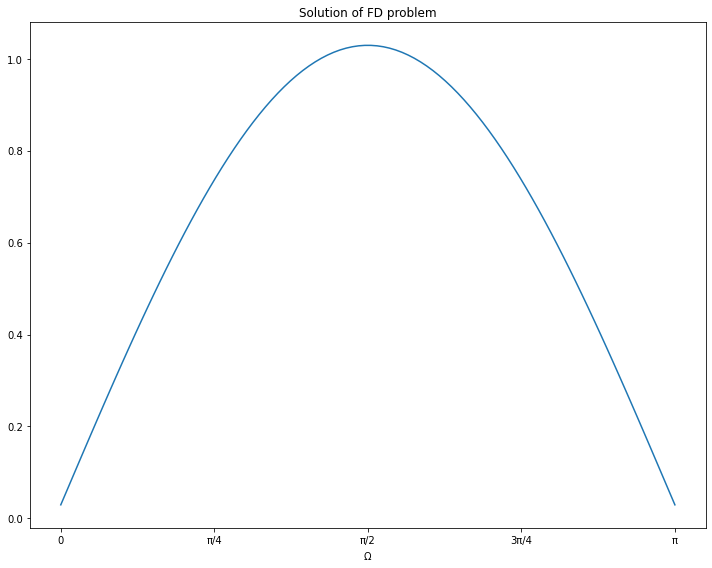

In [10]:
omega = [0, np.pi]
f = lambda x : np.sin(x)
n = 100
bc = [0,0]

A, b = finDif(omega, f, n, bc)  # find matrix A 
solved_system = solve_system(A,b, pivot=True)  # solve the system
plot_result(omega, solved_system)  # plot the solution 

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [11]:
def solve(omega, f, n, bc):
    '''
    Function to solve a finite difference problem.
    '''
    A, b = finDif(omega, f, n, bc)
    f_solve = solve_system(A, b, pivot=True)
    x = np.linspace(omega[0], omega[1], num=f_solve.shape[0]) # discretization points
    return x, f_solve

In [12]:
def plot_error(omega, f, bc, f_real):
    N = np.arange(50, 1200, step=200)
    er = np.zeros(N.shape[0])
    i = 0

    for n in N:
        x, f_solve = solve(omega, f, n, bc)
        er[i] = max( abs( f_solve - f_real(x) ) )
        i += 1
    
    plt.plot(N, er, label = "${\\Vert \\cdot \\Vert}_{\\infty}$")
    plt.xlabel("Iteration", fontsize=15)
    plt.ylabel("Error", fontsize=15, rotation=0, labelpad=20)
    plt.legend()
    plt.yscale("log")
    plt.title("Error vs number of iteartions", fontsize=18)
    plt.grid()

    return pd.DataFrame({"Iteration":N, "Error":er})


/home/elena/.local/lib/python3.8/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


,Iteration,Error
0,50,0.001578
1,250,0.000311
2,450,0.000172
3,650,0.000119
4,850,0.000091
5,1050,0.000074


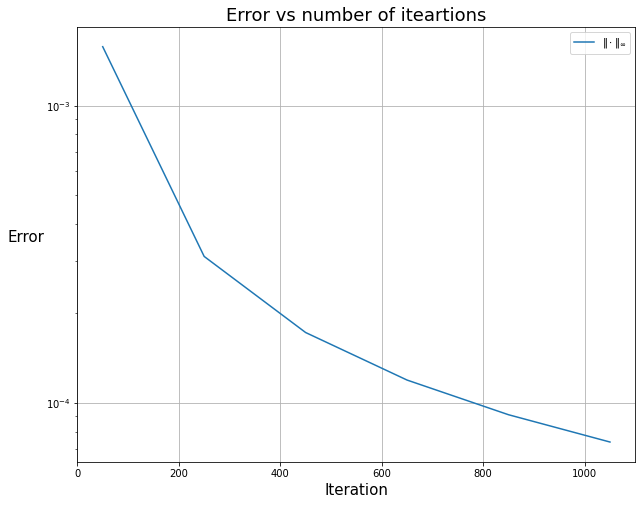

In [13]:
omega = [0,1]
bc = [0,0]
f = lambda x : x*(1-x)
f_real = lambda x: np.power(x,4) / 12 - np.power(x,3) / 6 + x / 12
error = plot_error(omega, f, bc, f_real)
error

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [14]:
def inverse(A):
    '''
    Function to compute the inverse of a square non singular 
    matrix using its LU factorization.
    '''
    A = np.array(A, dtype="float64")
    inv_A = np.zeros_like(A)
    I = np.identity(A.shape[0])
    L, U, P = LU(A, pivot=True)

    for k in range(A.shape[0]):
        tmp = L_solve(L, np.matmul(I[:, k],P))
        inv_A[:, k] = U_solve(U, tmp)
    return inv_A

In [15]:
def condNumb(A):
    A = np.array(A)
    A_inv = inverse(A)
    condNu = max( sum( np.abs(A), axis=1) ) * max( sum( np.abs(A_inv), axis=1) )
    return condNu 

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

Preconditioned Conjugate Gradient method:

$\texttt{Step 0:}$ 
- $ r^{(0)} = b-Ax^{(0)} $
- $ z^{(0)} = P^{-1} r^{(0)} $
- $ p^{(0)} = z^{(0)} $

$\texttt{Step k:}$ 
- $ \alpha_k = \frac{(p^{(k)})^T r^{(k)}}{(p^{(k)})^T A p^{(k)}} $
- $ x^{(k+1)} = x^{(k)} + \alpha_k p^{(k)} $
- $ r^{(k+1)} = r^{(k)} + \alpha_k A p^{(k)} $
- $ Pz^{(k+1)} = r^{(k+1)} $
- $ \beta_k = \frac{(Ap^{(k)})^T z^{(k+1)}}{(Ap^{(k)})^T p^{(k)}} $
- $ p^{(k+1)} = z^{(k+1)} - \beta_k p^{(k)} $

In [16]:
def conjugate_gradient(A, b, P=None, nmax=len(A), eps=1e-10):
    '''
    Function to apply the conjugate gradient method on a symmetric
    positive definite matrix A.
    '''
    # check conditions
    assert A.shape(A)[0] == A.shape[1], "The matrix is not square"
    assert np.allclose( A, A.transpose() ), "The matrix is not symmetric"
    _, U = LU(A, pivoting=False)
    assert all(np.diag(U) > 0), "The matrix is not positive definite"

    if P is None:
        P = np.identity(A.shape[0])  #if not as input, define the preconditioned matrix as the identity

    A = np.array(A, dtype="float64")
    b = np.array(b, dtype="float64")

    x = np.zeros_like(A[0])  # define the variable x_0
    r = b - A.dot(x)  # define the variable r_0
    z = solve_system(P, r)  # solve the system for z_0
    p = z
    for k in range(1, nmax):
        if np.linalg.norm(r) < eps:
            break

        alpha = p.dot(r) / A.dot(p).dot(p)  # alpha_k
        x += alpha * p  # x_(k+1) = x_k + alpha_k * z_k
        r -= alpha * A.dot(p)  #r_(k+1) = r_k - alpha_k * A * z_k
        z = solve_system(P, r)  # z_(k+1)
        beta = A.dot(p).dot(z) / A.dot(p).dot(p)  # beta_k
        p = z - beta * p  # p_(k+1) = z_(k+1) - beta_k * p_k
        
    return x

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

In [19]:
def forward_euler_method(f, alpha, omega, t0, tend, n, bc, Nt):
    '''
    Implemet forward Euler method to find solution x for the differential equation.
    It returns the solution x, the time t and the discretization points.
    '''
    h = ( tend - t0 ) / Nt  # define the time step h
    t = np.linspace(t0, tend, num = Nt+1, dtype="float64")

    u = np.zeros( (n, Nt+1) )  # to store the solution

    A, b = finDif(omega, f, n, bc)  # find FD solution of the problem
    x = np.linspace(omega[0], omega[1], num=b.shape[0])  # define discretization points
    u[:, 0] = solve_system(A, b)  # solve linear system for get initial solution at t0

    for k in range(Nt):
        u_xx = A.dot(u[:, k])  # compute derivative at step before
        alpha_0 = alpha( t[k] ) * b  # compute function at step before
        u[:,k+1] = u[:, k] - h * ( u_xx + alpha_0)

    return u, t, x


Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


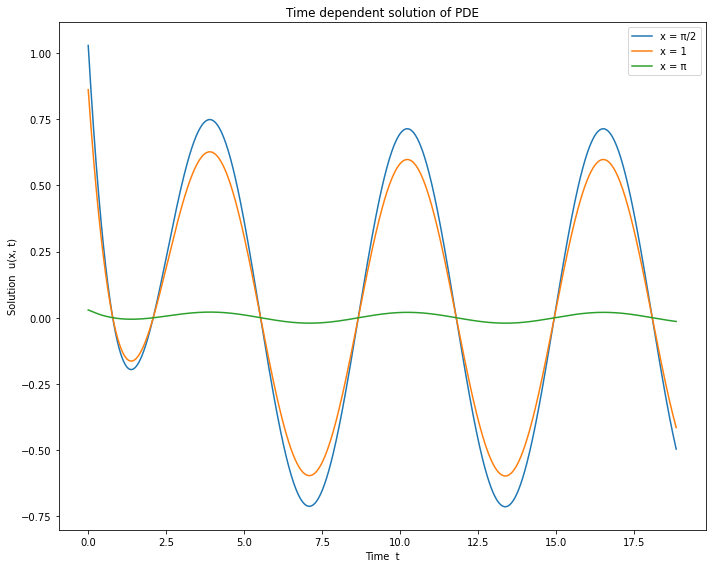

In [20]:
t0 = 0
tend = 6 * np.pi
Nt = 500000

alpha =  lambda t: np.cos(t)

f = lambda x : np.sin(x)
omega = [0, np.pi]
bc = [0,0]
n = 100 

u, t, x = forward_euler_method(f, alpha, omega, t0, tend, n, bc, Nt)

# find right indexes
idx_pi_half = round(n / (omega[-1] - omega[0]) * np.pi/2) -1
idx_one = round(n/(omega[-1] - omega[0])) - 1
idx_pi = round(n/(omega[-1] - omega[0]) * np.pi) - 1

plt.rcParams["figure.figsize"] = (10,8)

plt.plot(t, u[idx_pi_half,:], label = "x = π/2")
plt.plot(t, u[idx_one,:], label = "x = 1")
plt.plot(t, u[idx_pi,:], label = "x = π")

plt.xlabel("Time  t")
plt.ylabel("Solution  u(x, t)")
plt.legend()
plt.title("Time dependent solution of PDE")
plt.tight_layout()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [21]:
def inverse_power_method(A, mu, eps=1e-10, max_iter=1000):
    '''
    Given the system matrix A, the function found the eigenvalue close to
    number mu by inverse power method.
    '''
    x0 = np.random.rand(A.shape[0])
    y = x0 / np.linalg.norm( x0, 2 )

    Amu = A - mu * np.eye(A.shape[0])
    (L,U) = LU(Amu)

    err = eps + 1
    it = 0
    l = 0

    while err > eps and it < max_iter:
        q = L_solve( L, y )
        x = U_solve( U, q )

        y = x / np.linalg.norm( x, 2 )
        z = A.dot(y)

        l = y.T.dot(z)
        err = np.linalg.norm(z - l*y,2)
        it += 1

    return l,y

In [22]:
def eigenvalues(A, max_iter=1000):
    n = A.shape[0]
    evals = np.zeros(n)
    (L, U) = LU(A)  # find LU factorization

    for _ in range(max_iter):
        Anew = U.dot(L)  # obtain new A as product of U and L
        (L, U) = LU(Anew)  # factorize again the obtained A

    evals = np.sort(np.diag(Anew))  # extract the evalue from the diagonal 
    return evals

In [23]:
def eigenvectors(A, evals, eps=1e-5):
    n = A.shape[0]
    evectors = np.zeros_like(A)

    for idx in range(n):    # for each of the evalue
        _, eve = inverse_power_method( A, evals[idx] + eps )  # apply inverse power method to get evector
        evectors[:,idx] = eve

    return evectors

Compute the inverse of the matrix A exploiting the derived LU factorization

In [24]:
def inverse(A):
    A = np.array(A, dtype="float64")
    inv_A = np.zeros_like(A)
    I = np.identity(A.shape[0])
    L, U, P = LU(A, pivot=True)
    
    for k in range(A.shape[0]):
        tmp = L_solve(L, np.matmul(I[:, k],P))
        inv_A[:, k] = U_solve(U, tmp)
    return inv_A

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [25]:
def newton_method(f, df, x, eps=1e-10, max_iter=1000):
    '''
    Function to implement the Newton method to searh for the zeros of a function f.
    '''
    for _ in range(max_iter):
        x = x - f(x) / df(x)
        if( abs(f(x)) < eps ):
            return x
    return x

In [26]:
def backward_euler_method(y0, t0, tend, N=100):
    """
    Function to solve ordinary differential equation using Backward Euler and 
    employing the Newton method.
    """
    h = ( tend - t0 ) / N
    t = np.linspace(t0, tend, num=N+1, dtype="float64")
    y = np.zeros_like(t)
    y[0] = y0
    
    for k in range(1, N+1):
        f = lambda x : x - y[k-1] + h*t[k] * np.power(x, 2)
        df = lambda x : 1 + 2*h*t[k]*x
        y[k] = newton_method(f, df, y[k-1])

    return t, y

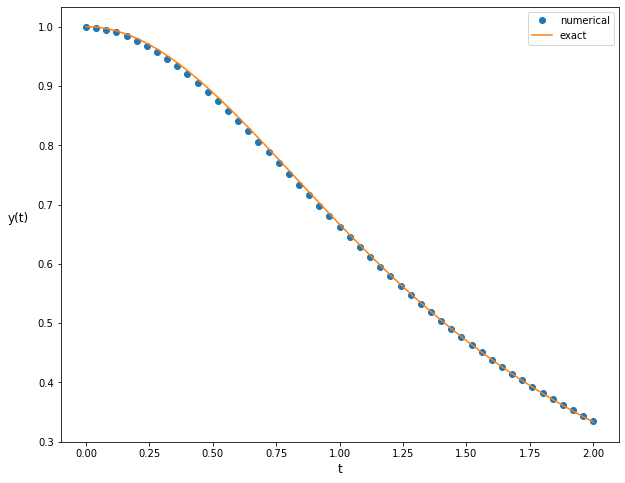

In [27]:
y0=1
t0 = 0
tend = 2
t, y = backward_euler_method(y0, t0, tend, N=50)
exact = lambda x: 2 / ( np.power(x, 2) + 2 )

plt.plot(t, y, 'o', label = 'numerical')
plt.plot(t, exact(t), label = 'exact')
plt.legend()
plt.xlabel("t", fontsize=12)
plt.ylabel("y(t)", fontsize=12, rotation=0, labelpad=20)
plt.show()

To visualize the error

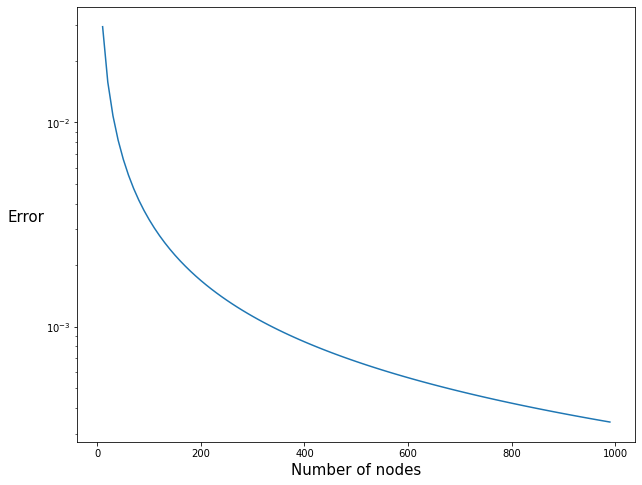

In [28]:
y0 = 1
t0 = 0
tend = 2
N = [i for i in range(10, 1000, 10)]
err = []
exact = lambda x: 2 / ( np.power(x, 2) + 2 )
for n in N:
    t, y = backward_euler_method(y0, t0, tend, n)
    err.append(max(abs(exact(t) - y)))

plt.plot(N, err)
plt.xlabel("Number of nodes", fontsize=15)
plt.ylabel("Error", fontsize=15, rotation=0, labelpad=20)
plt.yscale('log')
plt.show()